In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
from PIL import Image
import cv2
# import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

In [2]:
import numpy as np
import torch
import pandas as pd
import random
import string

In [3]:
model_name = 'efficientnet-b2'

In [4]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained(model_name) 

Loaded pretrained weights for efficientnet-b2


In [5]:
np.random.seed(42)

In [6]:
image_size = EfficientNet.get_image_size(model_name)

In [7]:
# def check_dataset_images(data_dir):
#     """
#     Some images in the dataset are corrupted or do not have any data, this method removes them
#     """
#     for i in os.listdir(data_dir):
#         for j in os.listdir(os.path.join(data_dir, i)):
#             try:
#                 img = Image.open(os.path.join(os.path.join(data_dir, i), j)) # open the image file
#                 img.verify() # verify that it is, in fact an image
#             except (IOError, SyntaxError) as e:
#                 print(j,"not real image - removing")
#                 if os.path.exists(os.path.join(os.path.join(data_dir, i), j)):
#                     os.remove(os.path.join(os.path.join(data_dir, i), j))

In [8]:
data_dir = '../../data/train/'
# check_dataset_images(data_dir)

In [9]:
src = (ImageList.from_folder(path=data_dir).split_by_rand_pct(0.2).label_from_folder())

In [10]:
res = []
res.append(rotate(degrees=(-90,90), p=1))

In [11]:
tfms=(res,[])

In [12]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH).databunch(bs=32).normalize(imagenet_stats))

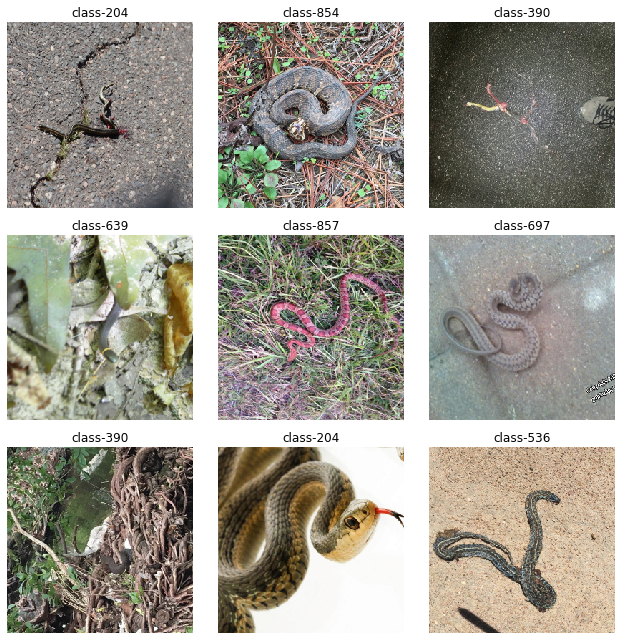

In [13]:
data.show_batch(3,figsize=(9,9))

In [14]:
list(children(model))[-2:]

[Linear(in_features=1408, out_features=1000, bias=True),
 MemoryEfficientSwish()]

In [15]:
model.add_module('_fc',nn.Linear(1408, data.c))

In [16]:
loss_func = LabelSmoothingCrossEntropy()

In [17]:
RMSprop = partial(torch.optim.RMSprop)

In [18]:
from torch.optim import Optimizer

In [19]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [20]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='micro'),kappa, Precision(average='micro'),
               Recall(average='micro')]).to_fp16()

In [21]:
learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:8]],
             [learn.model._blocks[8:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])
print("pls")

pls


In [22]:
lr=1e-3

In [23]:
learn.fit_one_cycle(40,max_lr=slice(lr/100,lr), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best_b2_40')])

epoch,train_loss,valid_loss,accuracy,f_beta,kappa_score,precision,recall,time
0,1.948719,1.794697,0.619547,0.619547,0.605123,0.619547,0.619547,19:58
1,1.841208,1.713059,0.648911,0.648911,0.637896,0.648911,0.648911,19:59
2,1.812960,1.676672,0.663653,0.663653,0.648499,0.663653,0.663653,20:03
3,1.760334,1.652212,0.671844,0.671844,0.647034,0.671844,0.671844,20:05
4,1.693046,1.650760,0.678093,0.678093,0.648742,0.678093,0.678093,20:01
5,1.648861,1.686613,0.664139,0.664139,0.642928,0.664139,0.664139,20:04
6,1.639389,1.633204,0.678760,0.678760,0.645835,0.678760,0.678760,20:05
7,1.587362,1.604967,0.689741,0.689741,0.652393,0.689741,0.689741,20:07
8,1.585754,1.581775,0.697507,0.697507,0.671005,0.697507,0.697507,20:08
9,1.511859,1.576776,0.703452,0.703452,0.682584,0.703452,0.703452,20:10


Better model found at epoch 0 with accuracy value: 0.619547426700592.
Better model found at epoch 1 with accuracy value: 0.6489109992980957.
Better model found at epoch 2 with accuracy value: 0.6636534333229065.
Better model found at epoch 3 with accuracy value: 0.6718437075614929.
Better model found at epoch 4 with accuracy value: 0.6780925989151001.
Better model found at epoch 6 with accuracy value: 0.6787599325180054.
Better model found at epoch 7 with accuracy value: 0.6897409558296204.
Better model found at epoch 8 with accuracy value: 0.6975065469741821.
Better model found at epoch 9 with accuracy value: 0.7034520506858826.
Better model found at epoch 10 with accuracy value: 0.7093368768692017.
Better model found at epoch 12 with accuracy value: 0.711945652961731.
Better model found at epoch 13 with accuracy value: 0.718619167804718.
Better model found at epoch 14 with accuracy value: 0.7214705944061279.
Better model found at epoch 16 with accuracy value: 0.7228659987449646.
Bett

In [24]:
save_name = model_name+"_trained_for_40"
learn.save(save_name, return_path=True)

PosixPath('../../data/train/models/efficientnet-b2_trained_for_40.pth')

In [25]:
name = model_name+"best_20"
learn.fit_one_cycle(20,max_lr=slice(lr/1000,lr/100), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name=name)])

epoch,train_loss,valid_loss,accuracy,f_beta,kappa_score,precision,recall,time
0,0.754612,1.483272,0.767882,0.767882,0.736851,0.767882,0.767882,19:56
1,0.758258,1.482917,0.769156,0.769156,0.740185,0.769156,0.769156,19:57
2,0.757911,1.481370,0.770066,0.770066,0.741232,0.770066,0.770066,19:55
3,0.755034,1.485453,0.768003,0.768003,0.737788,0.768003,0.768003,20:14
4,0.741814,1.484749,0.769581,0.769581,0.740085,0.769581,0.769581,20:05
5,0.747606,1.484226,0.769581,0.769581,0.739870,0.769581,0.769581,20:02
6,0.744307,1.485235,0.770127,0.770127,0.741401,0.770127,0.770127,20:01
7,0.749475,1.486162,0.769884,0.769884,0.737731,0.769884,0.769884,20:03
8,0.744952,1.484011,0.770369,0.770369,0.742197,0.770369,0.770369,45:53
9,0.744286,1.488556,0.770127,0.770127,0.741435,0.770127,0.770127,40:49


Better model found at epoch 0 with accuracy value: 0.7678820490837097.
Better model found at epoch 1 with accuracy value: 0.7691560983657837.
Better model found at epoch 2 with accuracy value: 0.7700661420822144.
Better model found at epoch 6 with accuracy value: 0.7701268196105957.
Better model found at epoch 8 with accuracy value: 0.7703694701194763.
Better model found at epoch 13 with accuracy value: 0.7715221643447876.


In [26]:
save_name = model_name+"_trained_another_20"
learn.save(save_name, return_path=True)

PosixPath('../../data/train/models/efficientnet-b2_trained_another_20.pth')